In [2]:
# =========== IMPORT LIBRARIES ============
import keras_tuner as kt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import itertools 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
from statsmodels.stats.diagnostic import acorr_ljungbox
import utils as ut
import warnings
import tensorflow as tf
# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
# =========== DATA SPLIT ============
data = pd.read_csv('modelling_data/weekly_data.csv')
data.date = pd.to_datetime(data.date)
# Filter data for AT01
data_at01 = data[data['at_code'] == 'AT01']
data_at01_mix = ut.data_split(data_at01, 'mix')
data_at01_mix['date'] = data_at01.date
data_at01_mix = data_at01_mix.set_index('date')
data_at01_mix.index.freq = 'W'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0361
Epoch 2/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0308
Epoch 3/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0310
Epoch 4/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0299
Epoch 5/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0300
Epoch 6

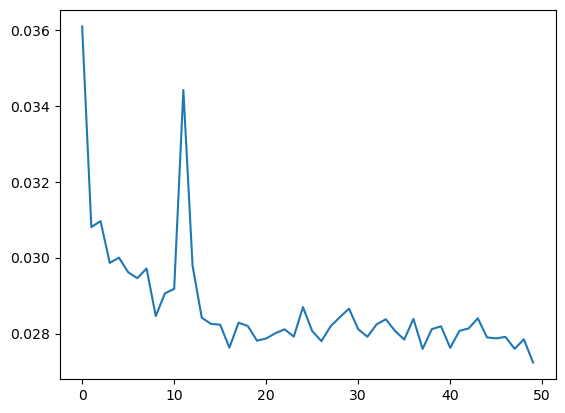

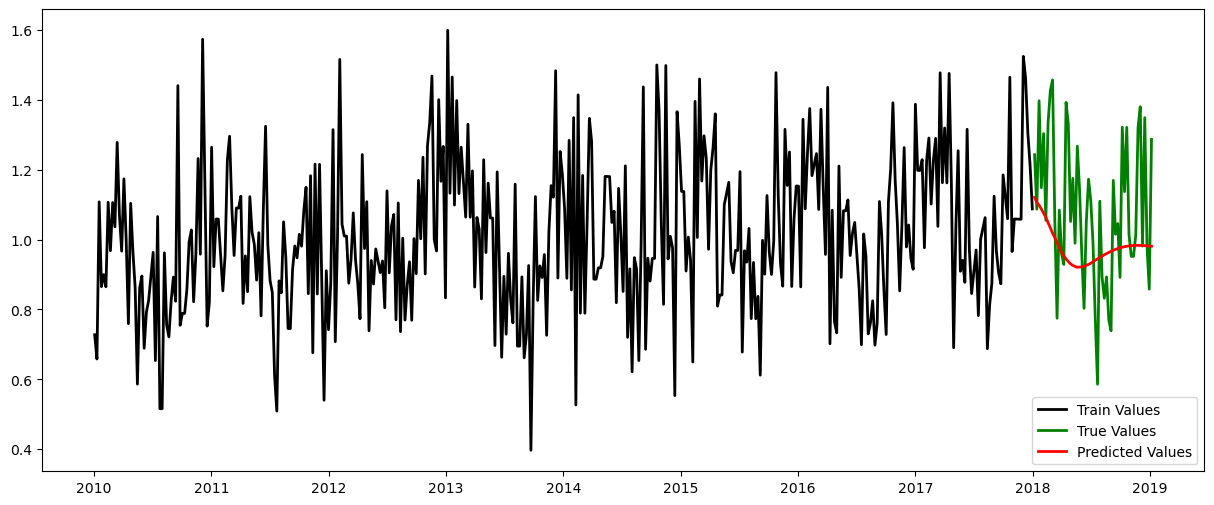

0.21761584375394935

In [3]:
df_train = data_at01_mix.loc[data_at01_mix.index < '2018-01-01'][['asir']] #, 'temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co'
df_test = data_at01_mix.loc[data_at01_mix.index >= '2018-01-01'][['asir']]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

n_inputs = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_inputs, batch_size =1)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape = (n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
model.fit(generator, epochs = 50)
plt.plot(model.history.history['loss'])
y_pred = []

first_batch = scaled_train[-n_inputs:]
current_batch = first_batch.reshape(1, n_inputs, n_features)

for i in range(len(scaled_test)):
    batch = current_batch
    pred = model.predict(batch)[0]
    y_pred.append(pred)
    current_batch = np.append(current_batch[:,1:, :], [[pred]], axis = 1)

y_pred_final = scaler.inverse_transform(y_pred)
df_test.values, y_pred_final
df_test['Predictions'] = y_pred_final
plt.figure(figsize=(15, 6))
plt.plot(df_train.index, df_train.asir, linewidth=2, color='black', label='Train Values')
plt.plot(df_test.index, df_test.asir, linewidth=2, color='green', label='True Values')
plt.plot(df_test.index, df_test.Predictions, linewidth=2, color='red', label='Predicted Values')
plt.legend()
plt.show()
from math import sqrt
sqrt(mean_squared_error(df_test.asir, df_test.Predictions))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 8)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               167200    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 167401 (653.91 KB)
Trainable params: 167401 (653.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0331
Epoch 2/50
388/388 [==============================] - 3s 8ms/step - loss: 0.0310
Epoch 3/50
388/388 [==============================] - 3s 7ms/step - loss: 0.0285
Epoch 4/50
388/388 [====================

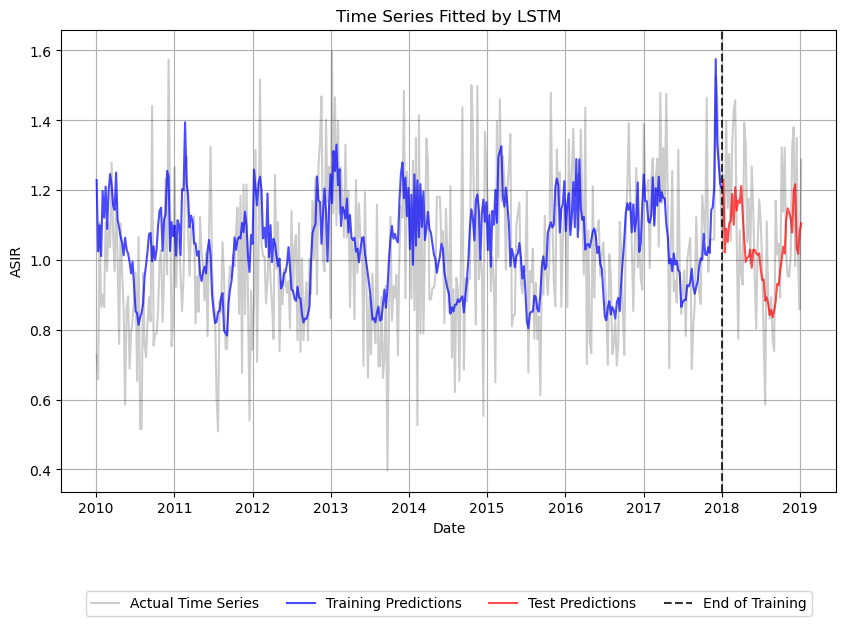

In [22]:
from keras.layers import Input, concatenate
from keras.models import Model

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =========== DATA SPLIT ============
data = pd.read_csv('modelling_data/weekly_data.csv')
data.date = pd.to_datetime(data.date)
# Filter data for AT01
data_at01 = data[data['at_code'] == 'AT01']
data_at01_mix = ut.data_split(data_at01, 'mix')
data_at01_mix['date'] = data_at01.date
data_at01_mix = data_at01_mix.set_index('date')
data_at01_mix.index.freq = 'W'

# Selecting both 'asir' (target) and exogenous variables for training and testing sets
df_train = data_at01_mix.loc[data_at01_mix.index < '2018-01-01'][['asir', 'temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']]
df_test = data_at01_mix.loc[data_at01_mix.index >= '2018-01-01'][['asir', 'temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']]

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

# Prepare TimeseriesGenerator for training data
n_inputs = 30  # Number of time steps (lags)
n_features = df_train.shape[1]  # Number of input features
generator = TimeseriesGenerator(scaled_train, scaled_train[:, 0], length=n_inputs, batch_size=1)

# Define LSTM model with exogenous inputs
input_seq = Input(shape=(n_inputs, n_features))
lstm_out = LSTM(200, activation='relu')(input_seq)
output = Dense(1)(lstm_out)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mse')

model.summary()

model.fit(generator, epochs=50)

# Initialize lists to store predictions and exogenous variables
y_pred = []
exog_vars = []

# Prepare initial batch for prediction
first_batch = scaled_train[-n_inputs:, :]
current_batch = first_batch.reshape((1, n_inputs, n_features))

# Predict and collect exogenous variables for each step in the test set
for i in range(len(scaled_test)):
    batch = current_batch
    pred = model.predict(batch)[0]
    y_pred.append(pred)
    
    # Collect exogenous variables for inverse transformation
    exog_vars.append(scaled_test[i, 1:])  # Excluding 'asir', taking only exogenous variables
    
    # Update current_batch with the predicted value and the next exogenous variables
    current_batch = np.append(current_batch[:, 1:, :], [[np.append(pred, scaled_test[i, 1:])]], axis=1)

# Convert lists to numpy arrays for inverse scaling
y_pred = np.array(y_pred).reshape(-1, 1)
exog_vars = np.array(exog_vars)

# Combine predicted 'asir' values with exogenous variables for inverse scaling
combined_pred = np.concatenate((y_pred, exog_vars), axis=1)

# Inverse transform combined predictions
y_pred_final = scaler.inverse_transform(combined_pred)[:, 0]  # Take only the 'asir' predictions

# Assign predictions back to df_test
df_test['Predictions'] = y_pred_final

# Initialize lists to store training predictions and exogenous variables
y_pred_train = []
exog_vars_train = []

# Prepare initial batch for prediction on training set
first_batch_train = scaled_train[-n_inputs:, :]
current_batch_train = first_batch_train.reshape((1, n_inputs, n_features))

# Predict and collect exogenous variables for each step in the training set
for i in range(len(scaled_train)):
    batch_train = current_batch_train
    pred_train = model.predict(batch_train)[0]
    y_pred_train.append(pred_train)
    
    # Collect exogenous variables for inverse transformation
    exog_vars_train.append(scaled_train[i, 1:])  # Excluding 'asir', taking only exogenous variables
    
    # Update current_batch with the predicted value and the next exogenous variables
    if i < len(scaled_train) - 1:
        current_batch_train = np.append(current_batch_train[:, 1:, :], [[np.append(pred_train, scaled_train[i + 1, 1:])]], axis=1)

# Convert lists to numpy arrays for inverse scaling
y_pred_train = np.array(y_pred_train).reshape(-1, 1)
exog_vars_train = np.array(exog_vars_train)

# Combine predicted 'asir' values with exogenous variables for inverse scaling
combined_pred_train = np.concatenate((y_pred_train, exog_vars_train), axis=1)

# Inverse transform combined predictions
y_pred_final_train = scaler.inverse_transform(combined_pred_train)[:, 0]  # Take only the 'asir' predictions

# Assign predictions back to df_train
df_train['Predictions'] = y_pred_final_train

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train.asir, label='Actual Time Series', color='black', alpha=0.2)
plt.plot(df_train.index, df_train.Predictions, label='Training Predictions', color='blue', alpha=0.7)
plt.plot(df_test.index, df_test.asir, color='black', alpha=0.2)
plt.plot(df_test.index, df_test.Predictions, label='Test Predictions', color='red', alpha=0.7)
plt.axvline(df_train.index[-1], color='k', linestyle='--', label='End of Training', alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by LSTM')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.grid(True)
plt.savefig('plots/LSTM_forecast_with_exogenous.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calculate evaluation metrics for LSTM
mae_lstm = mean_absolute_error(df_test.asir, df_test.Predictions)
mse_lstm = mean_squared_error(df_test.asir, df_test.Predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((df_test.asir - df_test.Predictions) / df_test.asir)) * 100

In [23]:
# Calculate evaluation metrics for LSTM
mae_lstm_train = mean_absolute_error(df_train.asir, df_train.Predictions)
mse_lstm_train = mean_squared_error(df_train.asir, df_train.Predictions)
rmse_lstm_train = np.sqrt(mse_lstm)
mape_lstm_train = np.mean(np.abs((df_train.asir - df_train.Predictions) / df_train.asir)) * 100

print("Evaluation metrics for training LSTM (Exogenous Variables):")
print(f"MAE: {mae_lstm_train:.3f}")
print(f"MSE: {mse_lstm_train:.3f}")
print(f"RMSE: {rmse_lstm_train:.3f}")
print(f"MAPE: {mape_lstm_train:.3f}%")

print("Evaluation metrics for testing LSTM (Exogenous Variables):")
print(f"MAE: {mae_lstm:.3f}")
print(f"MSE: {mse_lstm:.3f}")
print(f"RMSE: {rmse_lstm:.3f}")
print(f"MAPE: {mape_lstm:.3f}%")

Evaluation metrics for training LSTM (Exogenous Variables):
MAE: 0.157
MSE: 0.039
RMSE: 0.194
MAPE: 17.164%
Evaluation metrics for testing LSTM (Exogenous Variables):
MAE: 0.164
MSE: 0.038
RMSE: 0.194
MAPE: 15.338%


# FEATURE IMPORTANCE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assume your initial data preprocessing steps have already been executed and variables are ready:
# data_at01_mix, df_train, df_test, scaler, scaled_train, scaled_test

n_splits = 5
n_inputs = 30  # Number of time steps (lags)
n_features = df_train.shape[1]  # Number of input features

X = np.concatenate((scaled_train, scaled_test), axis=0)
y = np.concatenate((scaled_train[:, 0], scaled_test[:, 0]), axis=0)
exog_vars = np.concatenate((scaled_train[:, 1:], scaled_test[:, 1:]), axis=0)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

baseline_mae_list = []
feature_mae_dict = {i: [] for i in range(1, n_features)}  # Skip 'asir' (index 0)

for train_index, val_index in kf.split(X):
    X_train, X_valid = X[train_index], X[val_index]
    y_train, y_valid = y[train_index], y[val_index]
    exog_vars_valid = exog_vars[val_index]

    # Create TimeseriesGenerator for training data
    generator = TimeseriesGenerator(X_train, y_train, length=n_inputs, batch_size=32)

    # Define LSTM model with exogenous inputs
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_inputs, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit model on the training fold
    model.fit(generator, epochs=50, verbose=0)

    # Prepare validation data for prediction
    X_valid_seq = TimeseriesGenerator(X_valid, y_valid, length=n_inputs, batch_size=32)
    
    # Compute baseline MAE on validation set
    y_pred = model.predict(X_valid_seq).reshape(-1, 1)
    combined_pred = np.concatenate((y_pred, exog_vars_valid[:len(y_pred)]), axis=1)
    y_pred_final = scaler.inverse_transform(combined_pred)[:, 0]
    baseline_mae = mean_absolute_error(y_valid[n_inputs:], y_pred_final)
    baseline_mae_list.append(baseline_mae)

    for feature_index in range(1, n_features):  # Skip 'asir' feature (index 0)
        # Shuffle the feature
        X_valid_shuffled = X_valid.copy()
        np.random.shuffle(X_valid_shuffled[:, feature_index])

        # Prepare shuffled validation data for prediction
        X_valid_shuffled_seq = TimeseriesGenerator(X_valid_shuffled, y_valid, length=n_inputs, batch_size=32)

        # Compute MAE with shuffled feature
        y_pred_shuffled = model.predict(X_valid_shuffled_seq).reshape(-1, 1)
        combined_pred_shuffled = np.concatenate((y_pred_shuffled, exog_vars_valid[:len(y_pred_shuffled)]), axis=1)
        y_pred_final_shuffled = scaler.inverse_transform(combined_pred_shuffled)[:, 0]
        shuffled_mae = mean_absolute_error(y_valid[n_inputs:], y_pred_final_shuffled)
        
        feature_mae_dict[feature_index].append(shuffled_mae)

# Compute mean MAE values
mean_baseline_mae = np.mean(baseline_mae_list)
mean_feature_mae = {feature_index: np.mean(mae_list) for feature_index, mae_list in feature_mae_dict.items()}

# Calculate percentage increase in MAE due to shuffling each feature
percentage_increase_dict = {feature_index: ((mean_feature_mae[feature_index] - mean_baseline_mae) / mean_baseline_mae) * 100 for feature_index in feature_mae_dict.keys()}

# Print results
print(f"Baseline MAE: {mean_baseline_mae:.4f}")
for feature_index, mae in mean_feature_mae.items():
    print(f"Feature: {df_test.columns[feature_index]}, MAE: {mae:.4f}, Percentage Increase: {percentage_increase_dict[feature_index]:.2f}%")

# Create a DataFrame for visualization
feature_names = [df_test.columns[feature_index] for feature_index in feature_mae_dict.keys()]
mae_values = [mean_feature_mae[feature_index] for feature_index in feature_mae_dict.keys()]
percentage_increase = [percentage_increase_dict[feature_index] for feature_index in feature_mae_dict.keys()]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MAE': mae_values,
    'Percentage Increase': percentage_increase
})

In [90]:
# Feature importance results excluding 'is_holiday'
feature_importance_results = [
    {'feature': 'temp', 'mae': 0.1800374334385356},
    {'feature': 'hum', 'mae': 0.16892833029380916},
    {'feature': 'pm10', 'mae': 0.16242957292368101},
    {'feature': 'no2', 'mae': 0.16354500128764807},
    {'feature': 'so2', 'mae': 0.1639659084580116},
    {'feature': 'co', 'mae': 0.1629129334989266}
        ]

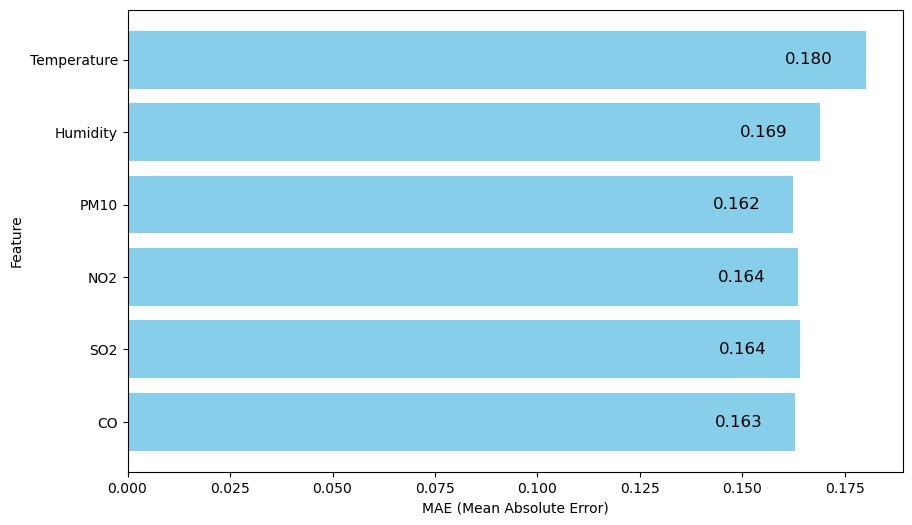

In [106]:
# Extracting feature names and MAE values
features = ['Temperature', 'Humidity', 'PM10', 'NO2', 'SO2', 'CO']
mae_values = [item['mae'] for item in feature_importance_results]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(features, mae_values, color='skyblue')
plt.xlabel('MAE (Mean Absolute Error)')
plt.ylabel('Feature')
plt.title('')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
# Adding values on top of bars
for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_width() - 0.008, bar.get_y() + bar.get_height()/2, f'{mae:.3f}', 
             va='center', ha='right', fontsize=12, color='black')
plt.savefig('plots/feature_importance.pdf', format='pdf', bbox_inches='tight')
plt.show()

# SCRIPT

Trial 5 Complete [00h 00m 14s]
val_loss: 0.023570379242300987

Best val_loss So Far: 0.021333251148462296
Total elapsed time: 00h 01m 30s

The optimal number of units in the first LSTM layer is 150 with a dropout rate of 0.5.

Epoch 1/100
12/12 [==============================] - 2s 41ms/step - loss: 0.1275 - val_loss: 0.0309
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0344 - val_loss: 0.0295
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0297 - val_loss: 0.0320
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0347
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0278 - val_loss: 0.0283
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0291 - val_loss: 0.0267
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.0269
Epoch 8/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0289

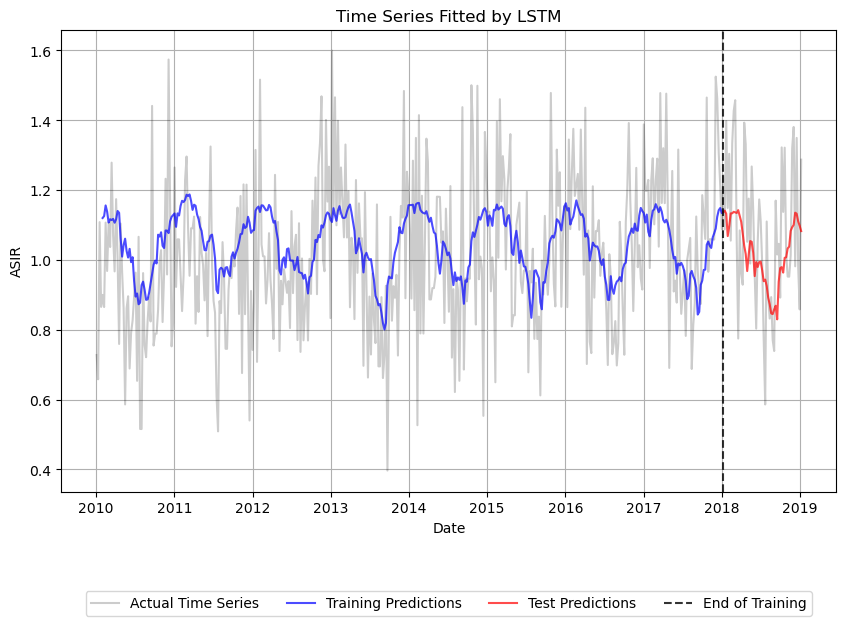

In [6]:
# Load your data into data_at03_mix if not already done
Y = data_at01_mix[['asir']]
X = data_at01_mix[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']]

# Store the original index before scaling
original_index = data_at01.date

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(X)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(Y)

# Create scaled DataFrame for train/test split
df_f_scaled = pd.DataFrame(scaled_features, index=original_index, columns=X.columns)
df_f_scaled['asir'] = scaled_target

# Function to create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X, y = create_sequences(scaled_features, scaled_target, seq_length)

# Split into train and test based on year 2018
train_end = df_f_scaled.loc[df_f_scaled.index < '2018-01-01'].index[-1]
train_index = df_f_scaled.index.get_loc(train_end) + 1

X_train = X[:train_index - seq_length]
y_train = y[:train_index - seq_length]
X_test = X[train_index - seq_length:]
y_test = y[train_index - seq_length:]

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define the LSTM model using Keras Tuner for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50)))
    model.add(Dense(1))
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='lstm_tuning_new',
    project_name='lstm_tuning'
)

tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units')} with a dropout rate of {best_hps.get('dropout')}.
""")

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = target_scaler.inverse_transform(train_predict)
y_train = target_scaler.inverse_transform(y_train)
test_predict = target_scaler.inverse_transform(test_predict)
y_test = target_scaler.inverse_transform(y_test)

# Evaluate the model
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'RMSE train: {train_score}')
print(f'RMSE test: {test_score}')

# Log-likelihood, AIC, and BIC calculations
def calculate_metrics(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    
    return log_likelihood, aic, bic

num_params = sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
log_likelihood_train, aic_train, bic_train = calculate_metrics(y_train, train_predict, num_params)
log_likelihood_test, aic_test, bic_test = calculate_metrics(y_test, test_predict, num_params)

# print(f'Log-Likelihood train: {log_likelihood_train}')
# print(f'Log-Likelihood test: {log_likelihood_test}')
# print(f'AIC train: {aic_train}')
# print(f'AIC test: {aic_test}')
# print(f'BIC train: {bic_train}')
# print(f'BIC test: {bic_test}')

# Calculate residuals for test set
test_residuals = y_test - test_predict
#print(acorr_ljungbox(test_residuals)[:1])

# Plot actual data and predictions
actual_data = np.hstack((target_scaler.inverse_transform(scaled_target), scaler.inverse_transform(scaled_features)))

train_years = original_index[seq_length:seq_length + train_index - seq_length]
test_years = original_index[seq_length + train_index - seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(original_index, actual_data[:, 0], label='Actual Time Series', color='black', alpha=0.2)
plt.plot(train_years, train_predict, label='Training Predictions', color='blue', alpha=0.7)
plt.plot(test_years, test_predict, label='Test Predictions', color='red', alpha=0.7)
plt.axvline(original_index[train_index], color='k', linestyle='--', label='End of Training', alpha = 0.8)
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by LSTM')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.grid(True)
plt.savefig('plots/LSTM_forecast.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calculate evaluation metrics for LSTM
mae_lstm = mean_absolute_error(y_test, test_predict)
mse_lstm = mean_squared_error(y_test, test_predict)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

